#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sn 
import matplotlib.pyplot as plt 


from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [5]:
df.sort_index(inplace=True)

In [6]:
df = df.resample('1H').sum()

In [7]:
df.index.is_monotonic

True

In [8]:
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Данные ресемплированы, расположены в хронологическом порядке<br>
Имеем датафрейм с датами 2018-03-01 по 2018-08-31

## Анализ

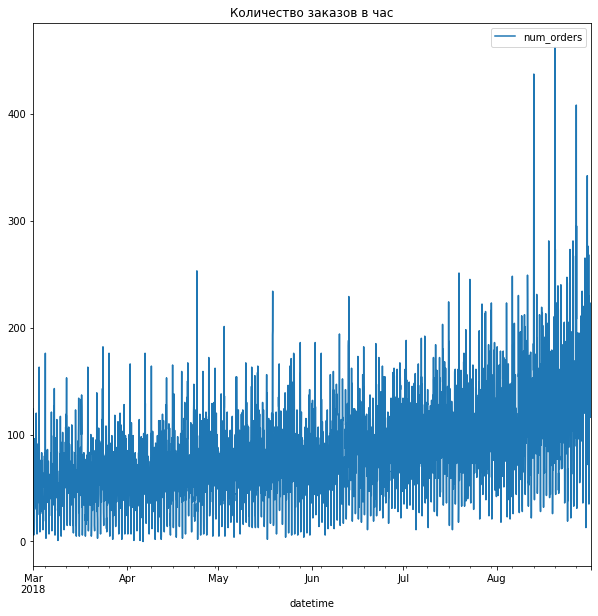

In [10]:
df.plot(figsize=(10, 10))
plt.title('Количество заказов в час')
plt.show()

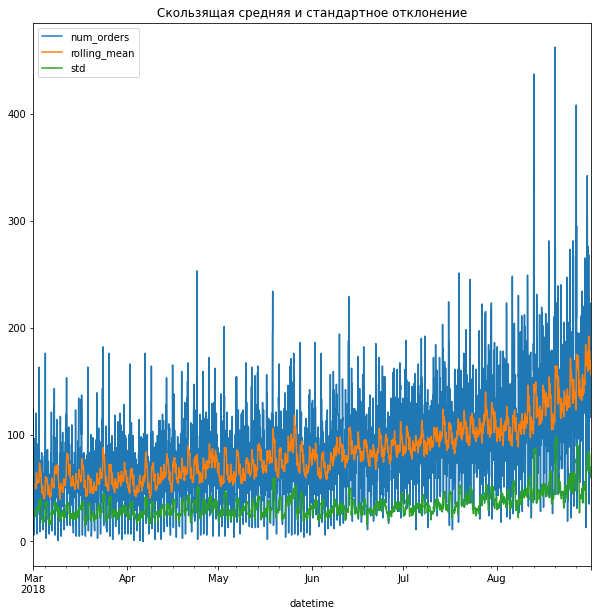

In [11]:
df['rolling_mean'] = df['num_orders'].rolling(20).mean() # создали колонку со скользящей средней
df['std'] = df['num_orders'].rolling(20).std() # создали колонку со стандартным отклонением
df.plot(figsize=(10, 10))
plt.title('Скользящая средняя и стандартное отклонение') # с скользящей средней
plt.show()

Посмотрим в цифрах равномерное ли изменение посясячно (мясяц к месяцу).

In [12]:
print(df['2018-04'].var(), "Апрель")
print(df['2018-05'].var(), "Мая")
print(df['2018-06'].var(), "Июнь")
print(df['2018-07'].var(), "Июль")
print(df['2018-08'].var(), "Август")


num_orders      1026.324600
rolling_mean     110.848898
std               48.722659
dtype: float64 Апрель
num_orders      1214.510282
rolling_mean     146.842638
std               69.644185
dtype: float64 Мая
num_orders      1077.597211
rolling_mean      99.637516
std               35.362119
dtype: float64 Июнь
num_orders      1387.917855
rolling_mean     114.589488
std               50.168805
dtype: float64 Июль
num_orders      3163.188206
rolling_mean     465.761939
std              230.580691
dtype: float64 Август


In [13]:
print((df['2018-05'].var() / df['2018-04'].var()- 1)*100, '%')
print('*'*30)
print(((df['2018-06'].var() / df['2018-05'].var())- 1)*100, '%')
print('*'*30)
print(((df['2018-07'].var() / df['2018-06'].var())- 1)*100, '%')
print('*'*30)
print(((df['2018-08'].var() / df['2018-07'].var())- 1)*100, '%')

num_orders      18.335883
rolling_mean    32.470994
std             42.940033
dtype: float64 %
******************************
num_orders     -11.273109
rolling_mean   -32.146740
std            -49.224592
dtype: float64 %
******************************
num_orders      28.797462
rolling_mean    15.006368
std             41.871602
dtype: float64 %
******************************
num_orders      127.908892
rolling_mean    306.461315
std             359.609696
dtype: float64 %


Мы видим, неравномерное изменение среднего и дисперсии, которые сильно меняеются со временем, значит временной ряд нестационарный.

In [14]:
data = df.copy()

Чтобы не менять значения семплирования исходной таблицы скопируем датафейм в новую переменную с семплированием по дням.

In [15]:
data = data.drop(['rolling_mean', 'std'], axis=1)

In [16]:
data = data.resample('1d').sum()

In [17]:
data

,num_orders
datetime,
2018-03-01,1364
2018-03-02,1506
2018-03-03,1290
2018-03-04,1141
2018-03-05,1259
...,...
2018-08-27,3936
2018-08-28,3357
2018-08-29,3762


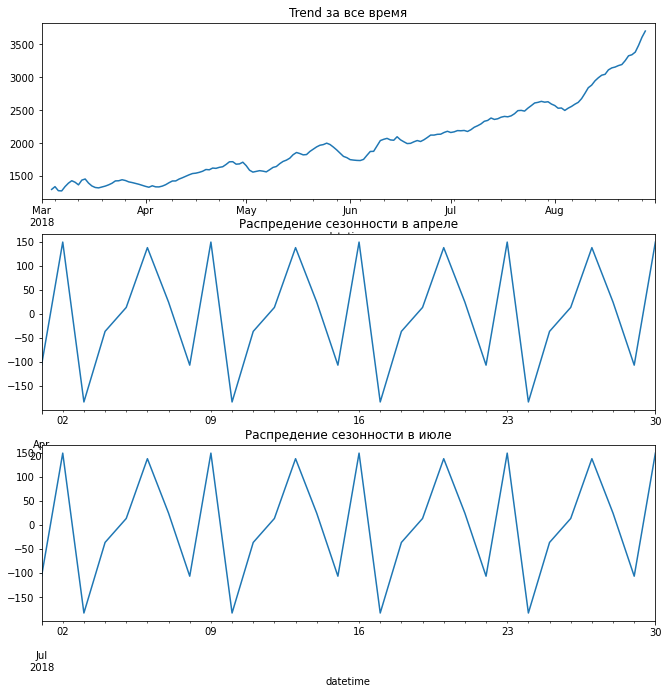

In [18]:
decomposed = seasonal_decompose(data) 

plt.figure(figsize=(11, 11))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend за все время')
plt.subplot(312)
decomposed.seasonal['2018-04-01' : '2018-04-30'].plot(ax=plt.gca())
plt.title('Распредение сезонности в апреле')
plt.subplot(313)
decomposed.seasonal['2018-07-01' : '2018-07-30'].plot(ax=plt.gca())
plt.title('Распредение сезонности в июле')
plt.show()

In [19]:
data1 = df.copy() # Создадим еще одну переменную с семплированным по 1 часу данным

In [20]:
data1 = data1.drop(['rolling_mean', 'std'], axis=1)
decomposed_hour = seasonal_decompose(data1) 

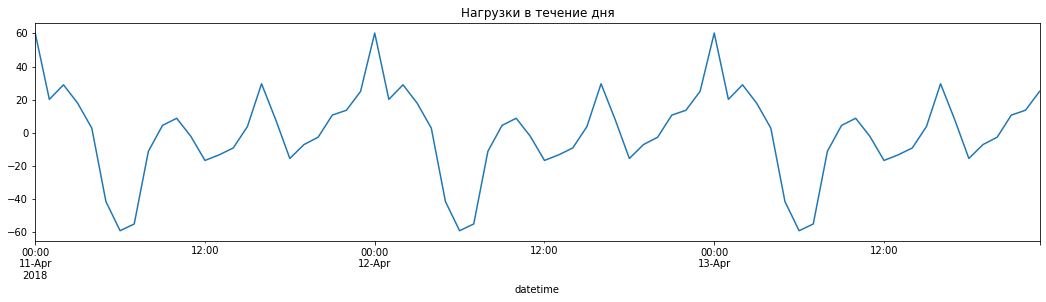

In [21]:
plt.figure(figsize=(18, 4))
decomposed_hour.seasonal['2018-04-11':'2018-04-13'].plot(ax=plt.gca()) 
plt.title('Нагрузки в течение дня')
plt.show()


**Вывод:** <br>
Количество заказов такси растет со временем. График распредение сезонности повторяется каждую неделю, значит количество заказов такси в текущей неделе по дням недели схож с количеством заказов по дням предыдущей недели. Имеюся сильные просадки в определенные дни недели и пиковые количества заказов. Также в течение дня видим пик спроса к 00 часов, далее падение до минимума заказов в 6 утра.

## Обучение моделей

In [22]:
df = df.drop(['rolling_mean'], axis=1) #удалим колонку со средним

Напишем функцию для создания признаков

In [23]:
def make_features(df, max_lag, rolling_mean_size):
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()




In [24]:
make_features(df, 24, 24)

Поделим общий датасет на обучающую и тестовую выборки. Тест = 10%. Место кросс-валидации будем использовать TimeSeriesSplit.

In [25]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

In [26]:
train = train.dropna()

test = test.dropna()

In [27]:
print(train.shape) 
print(test.shape)

(3950, 29)
(442, 29)


In [28]:
features_train = train.drop(['num_orders'], axis=1)
features_test = test.drop(['num_orders'], axis=1)


target_train = train['num_orders']
target_test = test['num_orders']

In [29]:
features_train

,std,hour,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,28.056100,0,2,4,58.0,113.0,66.0,61.0,45.0,73.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-02 01:00:00,29.494826,1,2,4,90.0,58.0,113.0,66.0,61.0,45.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-02 02:00:00,27.514398,2,2,4,120.0,90.0,58.0,113.0,66.0,61.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0
2018-03-02 03:00:00,25.182440,3,2,4,75.0,120.0,90.0,58.0,113.0,66.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0
2018-03-02 04:00:00,26.248358,4,2,4,64.0,75.0,120.0,90.0,58.0,113.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 09:00:00,86.479143,9,13,0,91.0,39.0,66.0,83.0,143.0,168.0,...,78.0,115.0,153.0,149.0,104.0,120.0,123.0,81.0,108.0,108.0
2018-08-13 10:00:00,86.098536,10,13,0,137.0,91.0,39.0,66.0,83.0,143.0,...,82.0,78.0,115.0,153.0,149.0,104.0,120.0,123.0,81.0,108.0
2018-08-13 11:00:00,86.088373,11,13,0,156.0,137.0,91.0,39.0,66.0,83.0,...,98.0,82.0,78.0,115.0,153.0,149.0,104.0,120.0,123.0,81.0


In [30]:
target_train

datetime
2018-03-02 00:00:00     90
2018-03-02 01:00:00    120
2018-03-02 02:00:00     75
2018-03-02 03:00:00     64
2018-03-02 04:00:00     20
                      ... 
2018-08-13 09:00:00    137
2018-08-13 10:00:00    156
2018-08-13 11:00:00    144
2018-08-13 12:00:00     92
2018-08-13 13:00:00    119
Freq: H, Name: num_orders, Length: 3950, dtype: int64

In [31]:
tscv = TimeSeriesSplit(n_splits=5)

**LinearRegression**

Найдем лучшие гиперпараметры для предсказания

In [32]:
%%time


lr_params = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
             
             
lr_model = LinearRegression()

grid_lr = GridSearchCV(estimator = lr_model, param_grid = lr_params, scoring='neg_mean_squared_error', cv=tscv)
grid_lr.fit(features_train, target_train)


best_hyperparams_lr = grid_lr.best_params_
best_score_lr = grid_lr.best_score_

print(best_hyperparams_lr)
print(best_score_lr)




{'copy_X': True, 'fit_intercept': False, 'normalize': True}
-748.9444774941217
CPU times: user 2.71 s, sys: 4.4 s, total: 7.12 s
Wall time: 7.1 s


In [33]:
%%time

lr_model = LinearRegression(copy_X = True, fit_intercept = False, normalize = True)

lr_model.fit(features_train, target_train)

pred = lr_model.predict(features_train)

mse_lr = mean_squared_error(target_train, pred)


print("RMSE обучающей выборки:", round(mse_lr**0.5, 2))


RMSE обучающей выборки: 25.52
CPU times: user 47.7 ms, sys: 54.9 ms, total: 103 ms
Wall time: 102 ms


**DecisionTreeRegressor**

In [34]:
%%time


DTR = DecisionTreeRegressor(random_state=12345,
                            max_depth=140)

numbers = list(range(1,240))
param = {'max_depth':numbers}
         
grid_CV = GridSearchCV(estimator = DTR, param_grid = param, scoring = 'neg_mean_squared_error', cv=tscv) 

grid_CV.fit(features_train, target_train)

best_hyperparams_dtr = grid_CV.best_params_
best_score_dtr = grid_CV.best_score_

print(best_hyperparams_dtr)
print(best_score_dtr)

{'max_depth': 5}
-930.5247333551008
CPU times: user 53.4 s, sys: 165 ms, total: 53.6 s
Wall time: 53.6 s


In [35]:
%%time 

DTR = DecisionTreeRegressor(random_state=12345,
                            max_depth=5)   


DTR.fit(features_train, target_train)

predictions = DTR.predict(features_train)

mse_dtr = mean_squared_error(target_train, predictions)

print("RMSE обучающей выборки:", round(mse_dtr**0.5, 2))

RMSE обучающей выборки: 24.59
CPU times: user 32.2 ms, sys: 4.02 ms, total: 36.3 ms
Wall time: 35.2 ms


**RandomForestRegressor**

In [36]:
%%time

model_rf = RandomForestRegressor(random_state=12345)

param_grid_rf = {
    'n_estimators': range(1, 100, 10),
    'max_depth': range(2, 20),
    
}

gs_rf = GridSearchCV(
    estimator = model_rf,
    param_grid=param_grid_rf, 
    scoring='neg_root_mean_squared_error',
    cv=tscv
)

gs_rf.fit(features_train, target_train)

gs_rf_best_score = gs_rf.best_score_ * -1
gs_rf_best_params = gs_rf.best_params_


print(f'best_score: {gs_rf_best_score}')
print(f'best_params: {gs_rf_best_params}')

best_score: 24.477367072339376
best_params: {'max_depth': 13, 'n_estimators': 71}
CPU times: user 11min 57s, sys: 2.45 s, total: 12min
Wall time: 12min


In [45]:
%%time

model_rf = RandomForestRegressor(random_state=12345,
                                n_estimators=71,   
                                max_depth=13)


model_rf.fit(features_train, target_train)

predictions = model_rf.predict(features_train)

mse_rf = mean_squared_error(target_train, predictions)

print("RMSE обучающей выборки:", round(mse_rf**0.5, 2))

RMSE обучающей выборки: 10.44
CPU times: user 3.29 s, sys: 16 ms, total: 3.3 s
Wall time: 3.3 s


**CatBoostRegressor**

In [38]:
%%time


catboost = CatBoostRegressor(loss_function="RMSE", iterations=1000)

catboost.fit(features_train, target_train, verbose=100)

predictions = catboost.predict(features_train)


mse_catboost = mean_squared_error(target_train, predictions)

print("RMSE обучающей выборки:", round(mse_catboost**0.5, 2))

Learning rate set to 0.050868
0:	learn: 37.7772269	total: 56.7ms	remaining: 56.6s
100:	learn: 21.3628893	total: 593ms	remaining: 5.28s
200:	learn: 19.1008240	total: 1.13s	remaining: 4.48s
300:	learn: 17.1441290	total: 1.68s	remaining: 3.9s
400:	learn: 15.6315759	total: 2.25s	remaining: 3.36s
500:	learn: 14.4721718	total: 2.87s	remaining: 2.86s
600:	learn: 13.4640580	total: 3.46s	remaining: 2.3s
700:	learn: 12.6206629	total: 4.08s	remaining: 1.74s
800:	learn: 11.8584247	total: 4.66s	remaining: 1.16s
900:	learn: 11.1605824	total: 5.23s	remaining: 574ms
999:	learn: 10.4874083	total: 5.78s	remaining: 0us
RMSE обучающей выборки: 10.49
CPU times: user 5.8 s, sys: 129 ms, total: 5.93 s
Wall time: 6.63 s


In [39]:
model= pd.Series(['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor', 'CatBoostRegressor'])
RMSE = pd.Series([mse_lr**0.5, round(mse_dtr**0.5, 2), round(mse_rf**0.5, 2), round(mse_catboost**0.5, 2)])


result = pd.DataFrame({'model':model, "RMSE":RMSE})
result

,model,RMSE
0,LinearRegression,25.51945
1,DecisionTreeRegressor,24.59000
2,RandomForestRegressor,8.46000
3,CatBoostRegressor,10.49000


## Тестирование

In [40]:
%%time

lr_model = LinearRegression(copy_X = True, fit_intercept = False, normalize = True)

lr_model.fit(features_train, target_train)

pred_test = lr_model.predict(features_test)

mse_lr1 = mean_squared_error(target_test, pred_test)


print("RMSE тестовой выборки:", mse_lr1**0.5)

RMSE тестовой выборки: 44.2801684858816
CPU times: user 43.6 ms, sys: 80 ms, total: 124 ms
Wall time: 90.2 ms


In [41]:
%%time 

DTR = DecisionTreeRegressor(random_state=12345,
                            max_depth=3)


DTR.fit(features_train, target_train)

predictions = DTR.predict(features_test)

mse_dtr1 = mean_squared_error(target_test, predictions)
print("RMSE тестовой выборки", round(mse_dtr1**0.5, 2))

RMSE тестовой выборки 62.49
CPU times: user 39 ms, sys: 31.9 ms, total: 70.9 ms
Wall time: 98.6 ms


In [46]:
%%time

model_rf = RandomForestRegressor(random_state=12345,
                                n_estimators=71,
                                max_depth=13)


model_rf.fit(features_train, target_train)

predictions = model_rf.predict(features_test)

mse_rf1 = mean_squared_error(target_test, predictions)

print("RMSE тестовой выборки:", round(mse_rf1**0.5, 2))

RMSE тестовой выборки: 41.76
CPU times: user 3.11 s, sys: 0 ns, total: 3.11 s
Wall time: 3.1 s


Learning rate set to 0.050868
0:	learn: 37.7772269	total: 6.41ms	remaining: 6.41s
100:	learn: 21.3628893	total: 650ms	remaining: 5.78s
200:	learn: 19.1008240	total: 1.23s	remaining: 4.89s
300:	learn: 17.1441290	total: 1.83s	remaining: 4.24s
400:	learn: 15.6315759	total: 2.35s	remaining: 3.52s
500:	learn: 14.4721718	total: 2.92s	remaining: 2.9s
600:	learn: 13.4640580	total: 3.44s	remaining: 2.29s
700:	learn: 12.6206629	total: 4s	remaining: 1.71s
800:	learn: 11.8584247	total: 4.54s	remaining: 1.13s
900:	learn: 11.1605824	total: 5.07s	remaining: 557ms
999:	learn: 10.4874083	total: 5.66s	remaining: 0us
RMSE тестовой выборки: 39.97


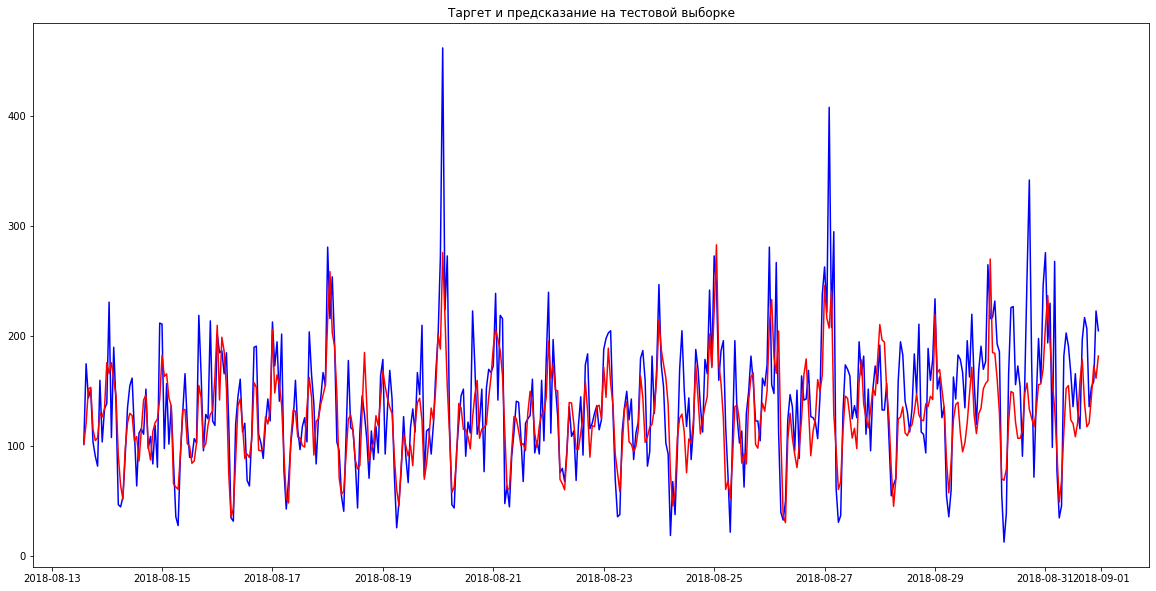

CPU times: user 6.1 s, sys: 153 ms, total: 6.26 s
Wall time: 6.91 s


In [43]:
%%time


catboost = CatBoostRegressor(loss_function="RMSE", iterations=1000)

catboost.fit(features_train, target_train, verbose=100)

predictions1 = catboost.predict(features_test)


mse_catboost1 = mean_squared_error(target_test, predictions1)

print("RMSE тестовой выборки:", round(mse_catboost1**0.5, 2))


df = df.resample('1H').sum()

plt.figure(figsize=(20, 10))
plt.plot(target_test.index, 
         target_test, 
         'b-', 
         target_test.index, 
         predictions1,
         'r-')
plt.title('Таргет и предсказание на тестовой выборке')
plt.show()

In [44]:
model= pd.Series(['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor', 'CatBoostRegressor'])
RMSE = pd.Series([mse_lr1**0.5, round(mse_dtr1**0.5, 2), round(mse_rf1**0.5, 2), round(mse_catboost1**0.5, 2)])


result = pd.DataFrame({'model':model, "RMSE":RMSE})
result

,model,RMSE
0,LinearRegression,44.280168
1,DecisionTreeRegressor,62.490000
2,RandomForestRegressor,41.800000
3,CatBoostRegressor,39.970000


## Вывод:

Мы получили датасет исторических данные о заказах такси в аэропортах. 
Выявили, количество заказов такси имеет тенденцию к еженедельной и каждодневной повторяемости к предыдущему периоду(сезонность). Мы провели анализ и подготовили данные для моделей. Подобрали лучшие параметры и обучили модели:
- LinearRegression
- DecisionTreeRegressor
- RandomForestRegressor
- CatBoostRegressor <br>

Путем проверки обученных моделей на тестовых выборках, пришли к выводу, что модель CatBoostRegressor дает лучшие показатели RMSE 39.9.